# Examples of Dynamic Ordered Persistence Editing (DOPE)

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
sys.path.append("..")
from utils import *
from mergetree import *
from matching import *
from matching_plots import *
import pyts.datasets

## Example 1: Examples from the UCR Dataset


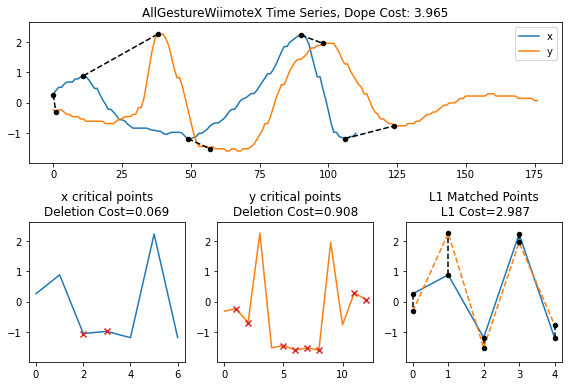

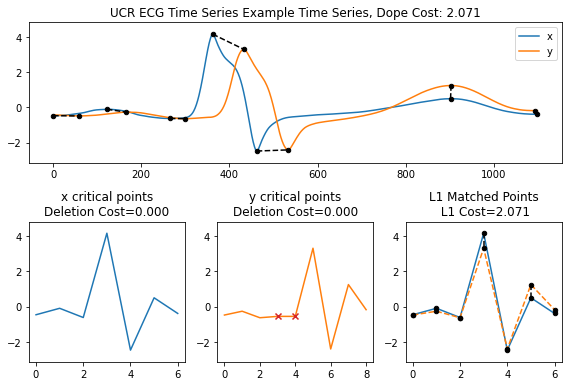

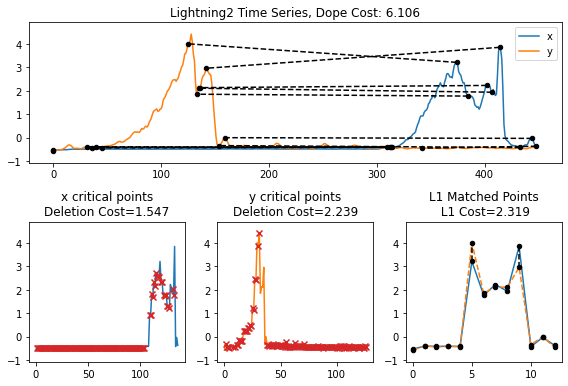

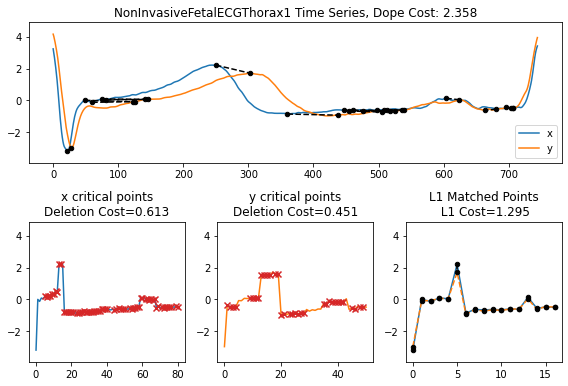

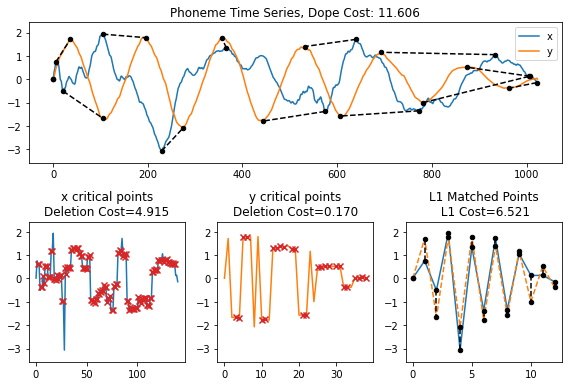

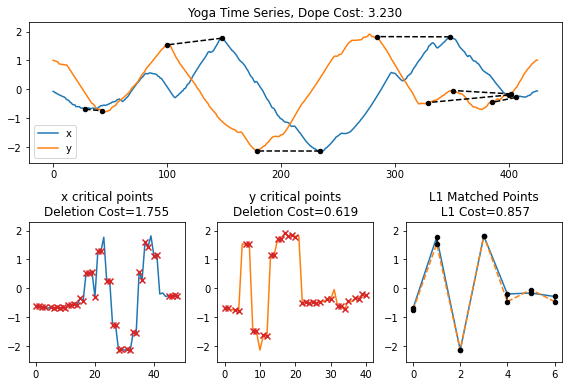

In [2]:
def mean_filt(x, kernel):
    res = np.cumsum(x)
    return (res[kernel::] - res[0:-kernel])/kernel


def plot_dataset(dataset, i, j, smooth_kernel, istart, iend, title=""):
    if len(title) == 0:
        title = dataset
    res = pyts.datasets.fetch_ucr_dataset(dataset)
    idx = np.argsort(res['target_train'])
    X = res['data_train'][idx, :]
    #print(dataset, res["DESCR"])

    circular = False
    plt.figure(figsize=(8, 8))

    x = X[i, :]
    x = x[~np.isnan(x)]
    if smooth_kernel > 0:
        x = mean_filt(x, smooth_kernel)
    if iend:
        x = x[istart:iend]
    x = znormalize(x)
    xc, xs, xc_idx = get_crit_timeseries(x, circular)

    y = X[j, :]
    y = y[~np.isnan(y)]
    if smooth_kernel > 0:
        y = mean_filt(y, smooth_kernel)
    if iend:
        y = y[istart:iend]
    y = znormalize(y)
    yc, ys, yc_idx = get_crit_timeseries(y, circular)

    cost, path = dope_match(x, y, circular)
    xdel, ydel = merge_chunks(path)
    plt.clf()
    plot_dope_matching(x, y, xc, xs, xc_idx, yc, ys, yc_idx, cost, xdel, ydel, plot_matches=True, plot_verified=False, tsname=title)
    plt.savefig("{}_{}_{}.svg".format(dataset, i, j), bbox_inches='tight', facecolor='white')

dataset = "AllGestureWiimoteX"
i = 211
j = 212
smooth_kernel = 0
istart = None
iend = None
plot_dataset(dataset, i, j, smooth_kernel, istart, iend)

dataset = "CinCECGtorso"
i = 16
j = 28
smooth_kernel = 100
istart = 300
iend = 1400
plot_dataset(dataset, i, j, smooth_kernel, istart, iend, "UCR ECG Time Series Example")

dataset = "Lightning2"
i = 9
j = 15
smooth_kernel = 5
istart = 100
iend = 550
plot_dataset(dataset, i, j, smooth_kernel, istart, iend)

dataset = "NonInvasiveFetalECGThorax1"
i = 795
j = 1498
smooth_kernel = 5
istart = None
iend = None
plot_dataset(dataset, i, j, smooth_kernel, istart, iend)

dataset = "Phoneme"
i = 141
j = 145
smooth_kernel = 0
istart = None
iend = None
plot_dataset(dataset, i, j, smooth_kernel, istart, iend)

dataset = "Yoga"
i = 0
j = 101
smooth_kernel = 0
istart = None
iend = None
plot_dataset(dataset, i, j, smooth_kernel, istart, iend)


## Example 1b: Figure for Introduction

wass_cost 2.006362014424751


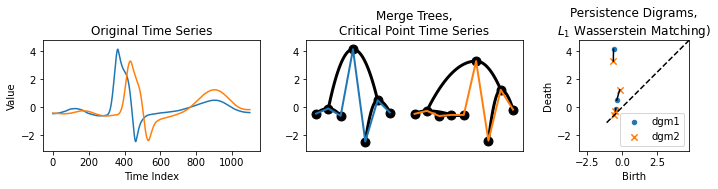

In [3]:
def plot_ts_with_mergetrees(dataset, i, j, smooth_kernel, istart, iend):
    res = pyts.datasets.fetch_ucr_dataset(dataset)
    idx = np.argsort(res['target_train'])
    X = res['data_train'][idx, :]
    #print(dataset, res["DESCR"])

    circular = False
    fac = 0.45
    plt.figure(figsize=(fac*22, fac*6))

    x = X[i, :]
    x = x[~np.isnan(x)]
    if smooth_kernel > 0:
        x = mean_filt(x, smooth_kernel)
    if iend:
        x = x[istart:iend]
    x = znormalize(x)
    xc, xs, xc_idx = get_crit_timeseries(x, circular)

    y = X[j, :]
    y = y[~np.isnan(y)]
    if smooth_kernel > 0:
        y = mean_filt(y, smooth_kernel)
    if iend:
        y = y[istart:iend]
    y = znormalize(y)
    yc, ys, yc_idx = get_crit_timeseries(y, circular)
    
    
    MTx = MergeTree(x)
    MTy = MergeTree(y)
    
    wass_cost, matching = wasserstein(MTx.PD, MTy.PD, matching=True)
    
    yvals = np.unique(MTx.get_rep_timeseries()['ys'])
    yvals = np.concatenate((yvals, np.unique(MTy.get_rep_timeseries()['ys'])))
    yvals = np.sort(np.unique(yvals))
    dy = yvals[-1] - yvals[0]
    
    plt.subplot2grid((1, 8), (0, 0), colspan=3)
    plt.plot(x)
    plt.plot(y)
    #plt.yticks(yvals, [chr(ord('a')+i) for i in range(yvals.size)])
    plt.ylim(yvals[0]-0.1*dy, yvals[-1]+0.1*dy)
    plt.title("Original Time Series")
    plt.xlabel("Time Index")
    plt.ylabel("Value")
    
    #plt.subplot(142)
    #MTx.plot(False)
    #plt.plot(x, linewidth=2)
    
    offset = 8
    pointsize = 80
    plt.subplot2grid((1, 8), (0, 3), colspan=3)
    MTx.plot(True, {"color":"k", "pointsize":pointsize})
    plt.plot(MTx.crit, c='C0', linewidth=2, zorder=10)
    MTy.plot(True, params={"offset":np.array([offset, 0]), "color":"k", "pointsize":pointsize})
    plt.plot(np.arange(MTy.crit.size)+offset, MTy.crit, c='C1', linewidth=2, zorder=10)
    plt.ylim(yvals[0]-0.1*dy, yvals[-1]+0.1*dy)
    plt.title("Merge Trees,\nCritical Point Time Series")
    plt.gca().set_xticks([])
    
    plt.subplot2grid((1, 8), (0, 6), colspan=2)
    plot_wasserstein_matching(MTx.PD, MTy.PD, matching)
    plt.xlim(yvals[0]-0.1*dy, yvals[-1]+0.1*dy)
    plt.ylim(yvals[0]-0.1*dy, yvals[-1]+0.1*dy)
    plt.title("Persistence Digrams,\n$L_1$ Wasserstein Matching)")
    print("wass_cost", wass_cost)
    
    plt.tight_layout()
    
    
dataset = "CinCECGtorso"
i = 16
j = 28
smooth_kernel = 100
istart = 300
iend = 1400
plot_ts_with_mergetrees(dataset, i, j, smooth_kernel, istart, iend)
plt.savefig("ECGConcept.svg", bbox_inches='tight')

## Example 2: Synthetic Noisy Trending Up Sinusoids

The example below shows DOPE matchings between two synthetic time series in a way that highlights our stability result, as well as its invariance to parameteriation.  Noise is added, but the distance does not exceed the amount of noise added.

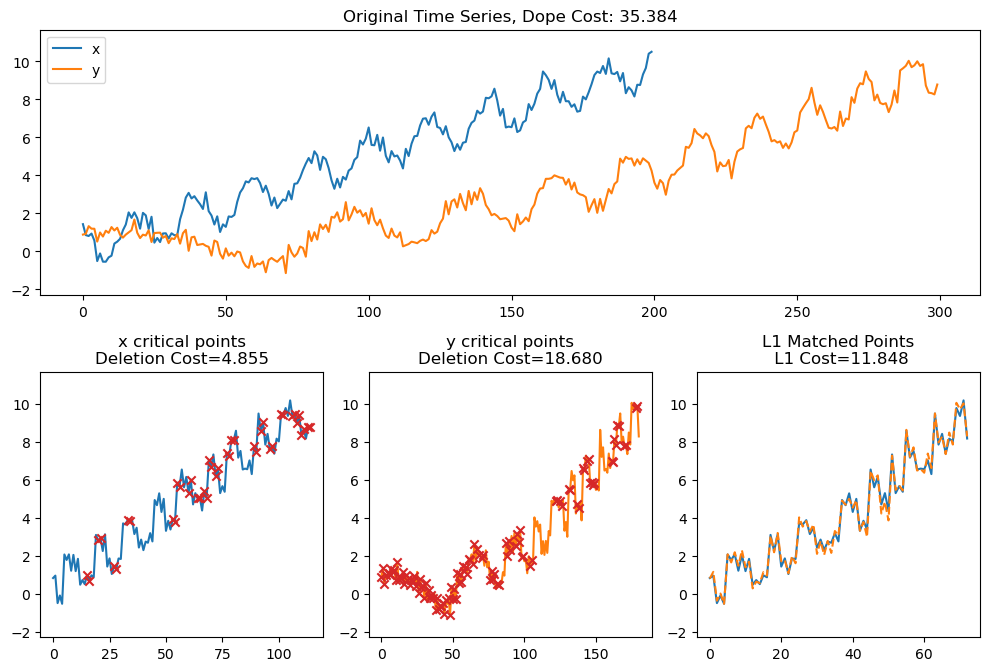

In [4]:
circular=False

np.random.seed(0)
N = 200
t = np.linspace(0.01, 0.98, N)
x = np.cos(2*np.pi*t*10) + t*10
x += 0.3*np.random.randn(N)
N = 300
t = np.linspace(0.01, 0.98, N)
y = np.cos(2*np.pi*(t**2)*10) + (t**2)*10
y += 0.3*np.random.randn(N)

xc, xs, xc_idx = get_crit_timeseries(x, circular)
yc, ys, yc_idx = get_crit_timeseries(y, circular)

cost, path = dope_match(x, y, circular)
xdel, ydel = merge_chunks(path)

plt.figure(figsize=(10, 10))
plot_dope_matching(x, y, xc, xs, xc_idx, yc, ys, yc_idx, cost, xdel, ydel, plot_matches=False, plot_verified=False)
plt.savefig("TrendUp.svg", bbox_inches='tight', facecolor='white')

#plt.savefig("WiiDOPE{}_{}.svg".format(i, j), bbox_inches='tight', facecolor='white')

## Example 3: Reflected Time Series

The example below highlights the informativity of our technique.  While methods based on persistence diagrams cannot tell the difference between reflected time series, DOPE forces pairs of critical points to match in time order, so it is forced to delete many pairs and pay a cost for time series that are reflected versions of each other

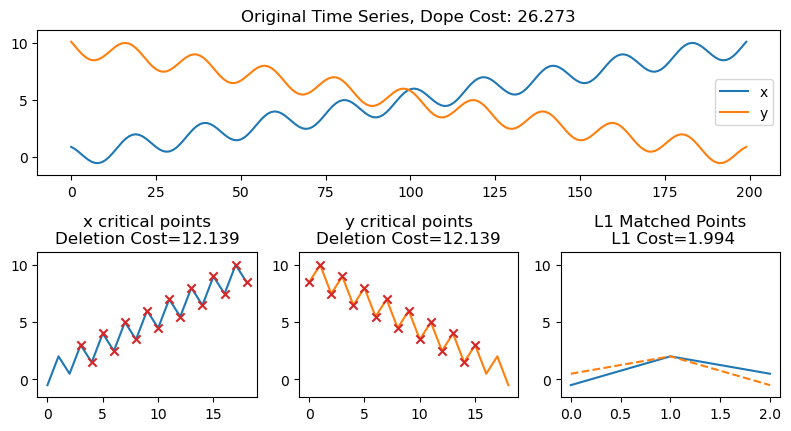

In [6]:
circular=False

np.random.seed(0)
N = 200
t = np.linspace(0.01, 0.98, N)
x = np.cos(2*np.pi*t*10) + t*10
N = 200
t = np.linspace(0.01, 0.98, N)
y = np.cos(2*np.pi*(t**2)*10) + (t**2)*10
y = x[::-1]

xc, xs, xc_idx = get_crit_timeseries(x, circular)
yc, ys, yc_idx = get_crit_timeseries(y, circular)

cost, path = dope_match(x, y, circular)
xdel, ydel = merge_chunks(path)

fac = 0.8
plt.figure(figsize=(10*fac, 8*fac))
plot_dope_matching(x, y, xc, xs, xc_idx, yc, ys, yc_idx, cost, xdel, ydel, plot_matches=False, plot_verified=False)
plt.savefig("Reflect.svg", bbox_inches='tight', facecolor='white')

#plt.savefig("WiiDOPE{}_{}.svg".format(i, j), bbox_inches='tight', facecolor='white')